# Tutorial 1: Simulation experiment

We utilized mouse visual cortex STARmap dataset to perform simulation experiment at a specific resolution (900 pixels). The raw dataset can be downloaded from [Dropbox](https://www.dropbox.com/sh/f7ebheru1lbz91s/AADm6D54GSEFXB1feRy6OSASa/visual_1020/20180505_BY3_1kgenes?dl=0&subfolder_nav_tracking=1). The raw dataset and simulated ST dataset were also provided at [Google Drive](https://drive.google.com/drive/folders/1yciYZ_9lYIhMuaoAaGqQsgbXcQ4aKDIv).

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import scanpy as sc
import STALocator
import scipy.sparse as sp

## Read data

In [2]:
data_path="../data/T1/"

# Read the binned ST dataset as anndata object.
adata_ST=sc.read(data_path+"T1_bin_data.h5ad")

# Read the STARmap dataset as anndata object.
adata_sc=sc.read(data_path+"T1_raw_data.h5ad")

# Cell type or spatial domain labels must be additionally stored in 'celltype' if they exist.
adata_sc.obs["celltype"]=adata_sc.obs["label"]

In [3]:
adata_ST

AnnData object with n_obs × n_vars = 127 × 1020
    obs: 'coord_1', 'coord_2', 'image_1', 'image_2', 'cell_count', 'L6', 'L4', 'L2/3', 'L1', 'CC', 'HPC', 'L5'
    obsm: 'spatial'

In [4]:
adata_sc

AnnData object with n_obs × n_vars = 1207 × 1020
    obs: 'Total_counts', 'X', 'Y', 'label', 'coord_1', 'coord_2', 'grid_1', 'grid_2', 'celltype'
    uns: 'label_colors'
    obsm: 'spatial'

In [5]:
sc.pp.filter_genes(adata_ST, min_cells=3)
sc.pp.filter_genes(adata_sc, min_cells=3)

## Run model

In [6]:
experiment_path="T1"
if not os.path.exists(experiment_path):
    os.makedirs(experiment_path)

In [7]:
model = STALocator.model.Model(resolution = "low", batch_size = adata_ST.shape[0], train_epoch = 10000, cut_steps = 0.5, 
                               sf_coord = 1, rad_cutoff = 0.6*np.sqrt(2), location = "spatial", 
                               seed = 123, lambdacos = 5, lambdaSWD = 5, lambdalat = 10, lambdarec = 0.1,
                               model_path = "T1/models", data_path = "T1/data", result_path = "T1/results", 
                               ot=False, device="cuda:0")

In [8]:
model.preprocess(adata_sc, adata_ST)

Finding highly variable genes...
Normalizing and scaling...
Dimensionality reduction via PCA...


In [9]:
model.train()

Begining time:  Thu Dec  7 03:53:01 2023
step 0, total_loss=501.5927, loss_D=4.6461, loss_GAN=3.7174, loss_AE=25.5866, loss_cos=1.9634, loss_LA=20.5434, loss_SWD=5.3517
step 500, total_loss=24.5518, loss_D=0.3378, loss_GAN=7.9267, loss_AE=0.9387, loss_cos=0.7170, loss_LA=0.2192, loss_SWD=0.2922
step 1000, total_loss=21.0371, loss_D=0.4350, loss_GAN=8.5776, loss_AE=0.6933, loss_cos=0.5333, loss_LA=0.1510, loss_SWD=0.2698
step 1500, total_loss=20.3248, loss_D=0.6711, loss_GAN=9.0104, loss_AE=0.6428, loss_cos=0.5254, loss_LA=0.1314, loss_SWD=0.1890
step 2000, total_loss=19.4596, loss_D=0.8002, loss_GAN=8.9754, loss_AE=0.6062, loss_cos=0.4466, loss_LA=0.1217, loss_SWD=0.1944
step 2500, total_loss=17.9858, loss_D=0.8359, loss_GAN=9.0171, loss_AE=0.4989, loss_cos=0.4485, loss_LA=0.1056, loss_SWD=0.1362
step 3000, total_loss=16.9410, loss_D=0.4406, loss_GAN=9.1972, loss_AE=0.4087, loss_cos=0.4039, loss_LA=0.0795, loss_SWD=0.1686
step 3500, total_loss=16.8453, loss_D=1.0550, loss_GAN=9.2325, l

In [10]:
model.eval()

Localized scRNA-seq dataset has been saved!


In [11]:
# Get localized scRNA-seq dataset from model
adata_sc_keep = model.adata_A_keep

In [12]:
adata_sc_keep

View of AnnData object with n_obs × n_vars = 1189 × 1020
    obs: 'Total_counts', 'X', 'Y', 'label', 'coord_1', 'coord_2', 'grid_1', 'grid_2', 'celltype', 'batch'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'label_colors', 'hvg', 'log1p'
    obsm: 'spatial', 'loc'

## Visualization of localization results

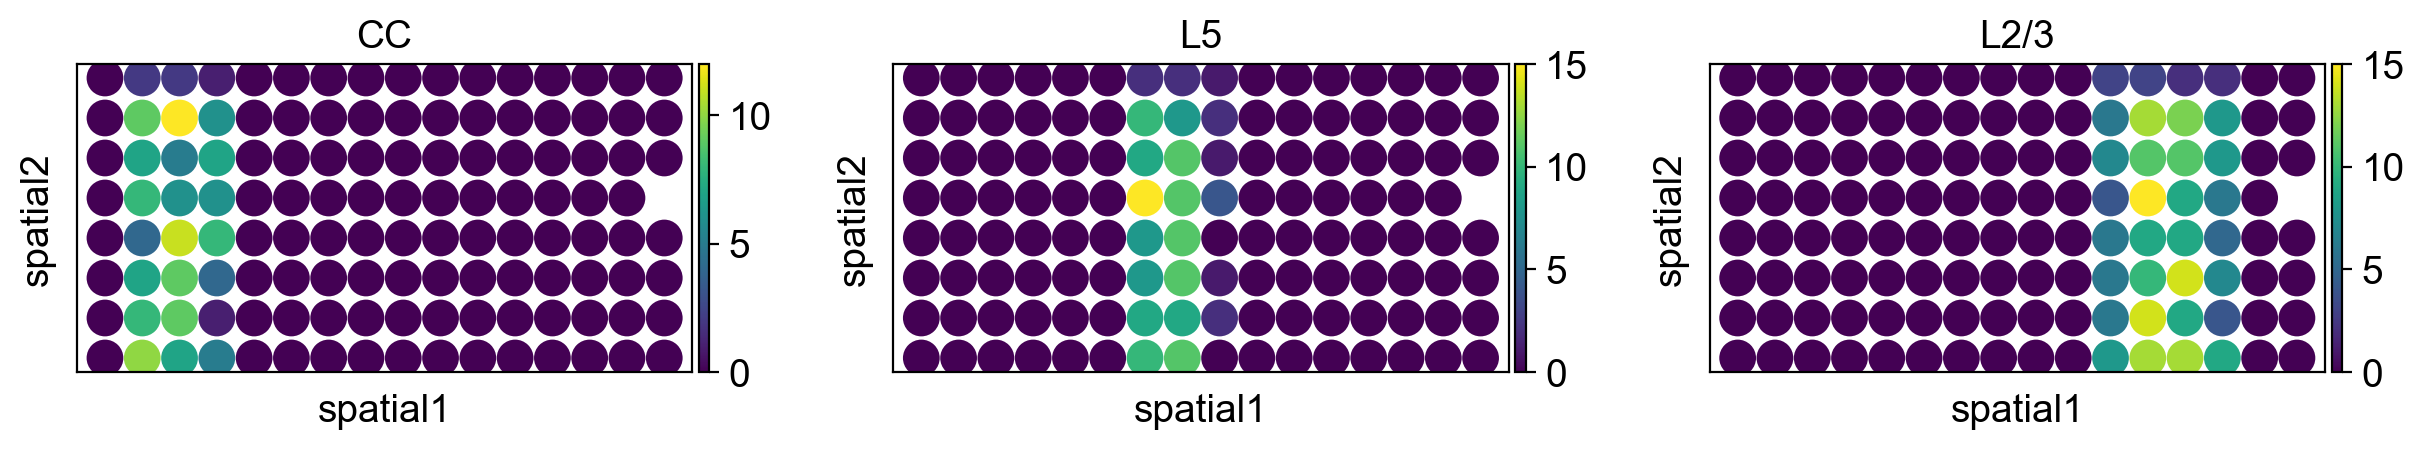

In [14]:
# Cell counts of selected cell types on the binned ST dataset
sc.set_figure_params(dpi=100, figsize=(4, 2))
sc.pl.embedding(adata_ST, basis="spatial", color=["CC","L5","L2/3"], s=700)

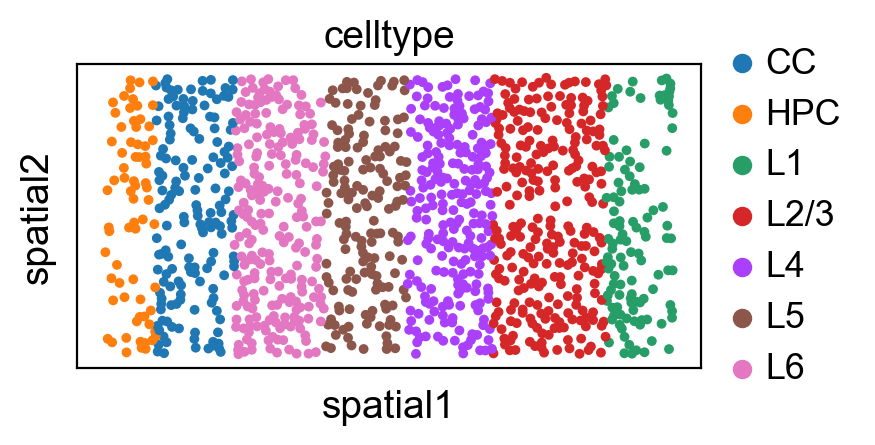

In [15]:
# Ground-truth
sc.pl.embedding(adata_sc, basis="spatial", color="celltype", s=50)

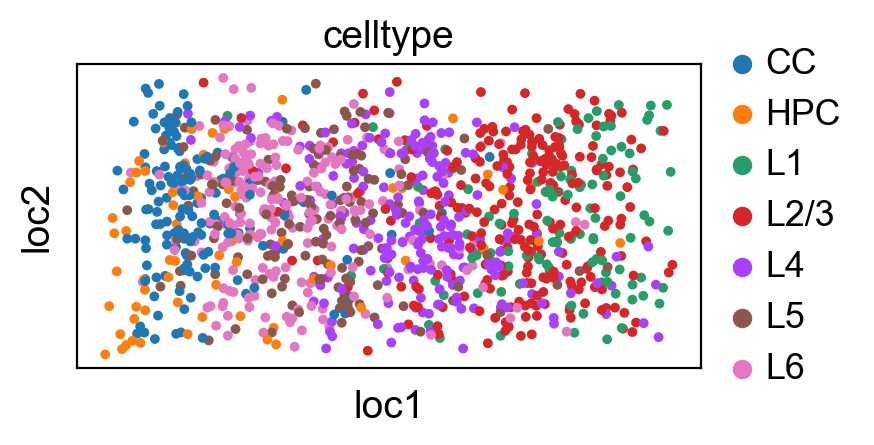

In [16]:
# Localization results
sc.pl.embedding(adata_sc_keep, basis="loc", color="celltype", s=50)